### 🐲코더의 소회 : 
날씨 : 오늘의 학습 < 적당히 맑음⛅ >했습니다. [☀️⛅☁️🌧️🌩️⛈️]
- 배운점 : 데이터셋에서 테이블 등 시각화 도구 사용하여 데이터셋이 장르별 대표성을 갖은 단어를 갖고 있나 확인하였고, 대표성을 갖은 단어들을 추출하는 것 통제하는 것의 중요성을 배웠다. 
- 아쉬운점 : 대표성을 어떻게 더 잘 나타나게 할까 조금 더 고민하고 싶었는데 그 부분을 더 진행하지 못해서 아쉽다. 
- 느낀점 : 항상 아쉬움이 없을 수는 없는 것 같다.

(참고 : https://github.com/Annyong2/AIFFEL_quest_rs/tree/master/GoingDeeper/Gdr03)

### ✅전체 코드 실행 플로우 (목차):

**🍀준비단계. 라이브러리, WEAT score함수, 장르 정의**  

**🍀STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기**  

**🍀STEP 2. 추출된 결과로 embedding model 만들기**  

**🍀STEP 3. target, attribute 단어 셋 만들기**  
- TF-IDF를 사용해서 단어 셋을 만들기 (&문제점)  
- TF-IDF외 방법으로 단어 셋을 만들기 (&장단점)  

**🍀STEP 4. WEAT score 계산과 시각화**  
- 편향성을 측정 및 WEAT score 계산  
- Heatmap로 시각화  


---

# 🍀준비단계. 라이브러리, WEAT score함수, 장르 정의
---

### 라이브러리

In [65]:
import os

import konlpy
from konlpy.tag import Okt
import gensim
from gensim.models import Word2Vec
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from numpy import dot
from numpy.linalg import norm

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pandas.plotting as pd_plotting

print("라이브러리 준비완료!✨")

라이브러리 준비완료!✨


### WEAT

In [2]:
# 두 벡터 간의 코사인 유사도를 계산하는 함수
def cos_sim(i, j):
    # 코사인 유사도 공식: (i ⋅ j) / (||i|| * ||j||)
    return dot(i, j.T) / (norm(i) * norm(j))

# 주어진 단어와 두 속성 집합(A와 B) 간의 유사도 차이를 계산하는 함수
def s(w, A, B):
    # w와 A(첫 번째 속성 집합) 간의 코사인 유사도 계산
    c_a = cos_sim(w, A)
    # w와 B(두 번째 속성 집합) 간의 코사인 유사도 계산
    c_b = cos_sim(w, B)
    
    # A와의 유사도 평균 계산
    mean_A = np.mean(c_a, axis=-1)
    # B와의 유사도 평균 계산
    mean_B = np.mean(c_b, axis=-1)
    
    # A와의 유사도 평균과 B와의 유사도 평균의 차이를 반환
    return mean_A - mean_B  # 필요 시 (c_a, c_b)도 반환 가능

# 예시 : '장미'라는 타겟 단어와 A, B 속성 간의 유사도 차이를 출력
# print(s(target_X['장미'], A, B))

def weat_score(X, Y, A, B):
    # 8-5 예시 참고
    # X, Y: 두 타겟 집합(디즈니 공주 vs 픽사 주인공)
    # A, B: 각 타겟과 연관될 수 있는 속성 집합 (공주가 좋아하는 것 vs 주인공이 좋아하는 것)
    
    # s_X: 타겟 X(공주들)와 속성 A, B 간의 유사도를 계산
    s_X = s(X, A, B)
    # s_Y: 타겟 Y(픽사 주인공들)와 속성 A, B 간의 유사도를 계산
    s_Y = s(Y, A, B)

    # 타겟 X의 유사도 평균 계산
    mean_X = np.mean(s_X)
    # 타겟 Y의 유사도 평균 계산
    mean_Y = np.mean(s_Y)
    
    # X와 Y의 유사도 분포 전체에 대한 표준편차 계산
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    # WEAT 점수: (타겟 X의 평균 - 타겟 Y의 평균) / 표준편차
    return (mean_X - mean_Y) / std_dev

print("weat_score 준비완료!✨")

weat_score 준비완료!✨


### 사용 영화구분 & 장르 구분

In [3]:
# 영화구분
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

# 장르 구분
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


print("길이 genre_txt : ",len(genre_txt))
print("길이 genre_name : ",len(genre_name))
print()
print("genre 정의완료!✨")

길이 genre_txt :  21
길이 genre_name :  21

genre 정의완료!✨


---

# 🍀STEP 1. 형태소 분석기를 이용하여 단어(명사) 추출하기  

- (품사가 명사인 경우 해당 단어를 추출하기)
---

### 단어(명사)추출

In [4]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


In [8]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [9]:
# 확인  
print(f"추출된 단어 수: {len(tokenized)}")
print(f"Type_tokenized: {type(tokenized)}")

추출된 단어 수: 71156
Type_tokenized: <class 'list'>


👁️👁️Data Review : 

---

# 🍀STEP 2.추출된 결과로 embedding model 만들기
---

In [10]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [11]:
model.wv.most_similar(positive=['그녀'])

[('남자에게', 0.7777436375617981),
 ('고백', 0.7573670148849487),
 ('손길', 0.7397060394287109),
 ('유혹', 0.7388468384742737),
 ('예전', 0.7360588908195496),
 ('형부', 0.7353227138519287),
 ('잠자리', 0.734588623046875),
 ('자위', 0.7344325184822083),
 ('해소', 0.7340690493583679),
 ('정사', 0.7301876544952393)]

In [12]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.721673309803009),
 ('첫사랑', 0.7034116983413696),
 ('만남', 0.6979587078094482),
 ('애정', 0.6976996064186096),
 ('토마슈', 0.6911329030990601),
 ('진심', 0.6887891292572021),
 ('종이학', 0.6841506361961365),
 ('고백', 0.6819244027137756),
 ('아픔', 0.6818125247955322),
 ('우정', 0.6807416081428528)]

In [72]:
model.wv.most_similar(positive=['코믹'])

[('코미디', 0.9668002128601074),
 ('주제', 0.95622318983078),
 ('판타지', 0.9470859169960022),
 ('형식', 0.944570779800415),
 ('유머', 0.9404201507568359),
 ('대사', 0.9402077794075012),
 ('요소', 0.9389370083808899),
 ('서사', 0.9355441331863403),
 ('소재', 0.9349092245101929),
 ('결합', 0.9283390641212463)]

👁️👁️Data Review : 뭔가 잘 나온 듯하다

---

# 🍀STEP 3. target, attribute 단어 셋 만들기
- TF-IDF를 사용해서 단어 셋을 만들기 (&문제점)   
- TF-IDF외 방법으로 단어 셋을 만들기 (&장단점)  
--- 

In [13]:
def read_token_1(file_name):
    okt = Okt()
    result = set()  # 중복을 제거하기 위해 set 사용
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: 
                break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ['Noun']:  # 명사일 때만 저장
                    result.add(word[0])  # set에 추가 (중복 제거)

    # 중복 제거된 단어들을 리스트로 변환 후, 문자열로 결합해서 반환
    result_list = list(result)  
    return ' '.join(result_list)

장르별 중복 단어를 제거함.  


중복은 추출한 명사를 list가 아닌 **집합(set)에 저장하여 중복을 방지**하였고, 해당 set는 중복제거후 list로 변환하였습니다.

### 파일을 읽고 벡터화하기

In [14]:
art = read_token_1(art_txt)  # 예술영화 파일에서 중복 제거된 단어 추출
gen = read_token_1(gen_txt)  # 일반영화 파일에서 중복 제거된 단어 추출


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.
(2, 41082)


In [15]:
#확인
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(200):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(200):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
프리펙트, 타우리, 비행접시, 움익, 스캐빈저, 심험, 차학경, 스텐턴, 레베, 머록, 토튼코픈, 맥너슨, 낸츠, 탄탈, 제닌, 옥스, 래닝, 익키, 벌칸, 외마디, 사박, 제브라맨, 결합체, 분자생물학, 스파크스, 설문, 기아로, 신경심리학, 중앙아메리카, 가까스레, 뷰러, 미래엔, 요오드, 인젠, 기후학자, 이족, 쇄국, 전달자, 하콘, 움푹, 무례, 크레센, 애브, 사이클론, 와칫부인, 효찬, 스판덱스, 알지바, 갠트, 코포레이션, 사이버링크, 조교수, 셀레스테, 기생동물, 칼엘, 힙겹, 포토샵, 트렌턴, 박보검, 슬레이트, 구조도, 송수관, 로트와일러, 기웅, 에슐린, 정지훈, 큐티, 스터너, 기계공학자, 앙트와넷, 스트링, 일산화탄소, 사피, 큐티브, 한코, 소제, 지층, 써로게이트, 블랙옥스, 윗윅키, 태양신, 비트리, 전자기, 게릴라군, 제크, 네멕, 헬릭스, 로켄, 무생물, 물통이, 모체, 오르쿠스, 코타키나발루, 노매드, 블루홀, 빙하시대, 크룸, 간구, 분파, 달무리, 애머티, 산성비, 인서전트, 콜로서스, 리군, 바칸, 헤네시, 기글스, 코언, 그래버, 미들타운, 버무려낸, 락웰, 런딤, 무균, 러다이트, 메타데이타, 섹트, 가고일, 왕형, 그레고리오, 우주성, 로도스, 불명료, 팔뚝, 육천, 천일이, 이동용, 사이언스, 윌포드, 더디츠, 웅얼거림일, 노송, 무버, 포믹, 스파르티, 면역체, 프로메테우스, 익부, 페어필드, 싸이보그, 특별출연, 켈빈, 스니프, 헤클, 겔드, 헤들런드, 스몰빌, 캐파, 천사일, 츠타, 프로토타입, 쉬프터, 시네마스코프, 헉몬, 사화산, 스투어트, 미노스, 할름, 인더스, 세포분열, 쿠롤로, 제국의아이들, 어찌하여, 몽거, 시민케인, 피즐, 오토마타, 강수진, 마태복음, 플리머스, 트릴리언, 레빌, 오스뮴, 워로드, 스노클링, 투롭, 전대원, 치베, 질산염, 빈익, 지표면, 옥신, 둘둘, 비커스, 영건, 딕테, 고글, 중간권, 토튼코프, 페퍼포츠, 이상기후, 하몬드, 스팍, 촉새, 

### TF-IDF를 적용했을 때의 문제점 해결 시도(1/2)
1. **중복 단어 문제**: 
    TF-IDF는 특정 장르에서 높은 빈도로 나타나는 단어를 높은 가중치로 선정하지만, 다른 장르에서도 흔하게 나타나는 단어일 수 있습니다. 이러한 중복 단어가 포함되면, 각 장르를 잘 대표하지 못하게 됩니다.   
    
    **개선 시도**
    - w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다. # <개선>  
    - w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다. # <개선>  
    이 두 부분에서는 각 단어 셋에서 중복된 단어를 제외하고 다른 집합에 속하지 않은 단어들만을 추출합니다.    
    
    => 이를 통해 각 장르를 더 잘 대표하는 단어 셋을 구축하여 중복 단어 문제를 개선했습니다.
    

In [21]:
n = 15
w1_, w2_ = [], []
for i in range(200):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다. # <개선>
target_art, target_gen = [], []
for i in range(200):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다. # <개선>
for i in range(200):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break   

print(f'target_art길이 :{len(target_art)}','\n')
print(target_art,'\n')
print(f'target_gen길이 : {len(target_gen)}','\n')
print(target_gen)

target_art길이 :15 

['벌칸', '제브라맨', '쇄국', '기생동물', '트렌턴', '송수관', '써로게이트', '블랙옥스', '게릴라군', '제크', '분파', '산성비', '콜로서스', '코언', '가고일'] 

target_gen길이 : 15 

['누키', '스위드', '크누드', '슈이트', '최호', '아주르', '볼러스', '크시', '마갈', '매킷', '씨제이', '콜랴', '블리자드', '전폐', '왕창']


⚠️**'오류아닌오류'기록 및 수정**  
target_art길이(12)와 target_gen길이(15)가 다르다.   
WordVec의 range를 늘려야 할 것 같다.  
(왜 늘리는가? WordVec 단어사전에서 100개 고른 단어중 target_art에는 있고 target_gen에는 없는 것 찾아야 하니, 위 조건에 해당하는 단어가 15개미만이 될 수도 있음)  
-> Trail #01 : range(100) -> range(**200**) => target_art길이 :**15 <SUCCESS🎉>**  

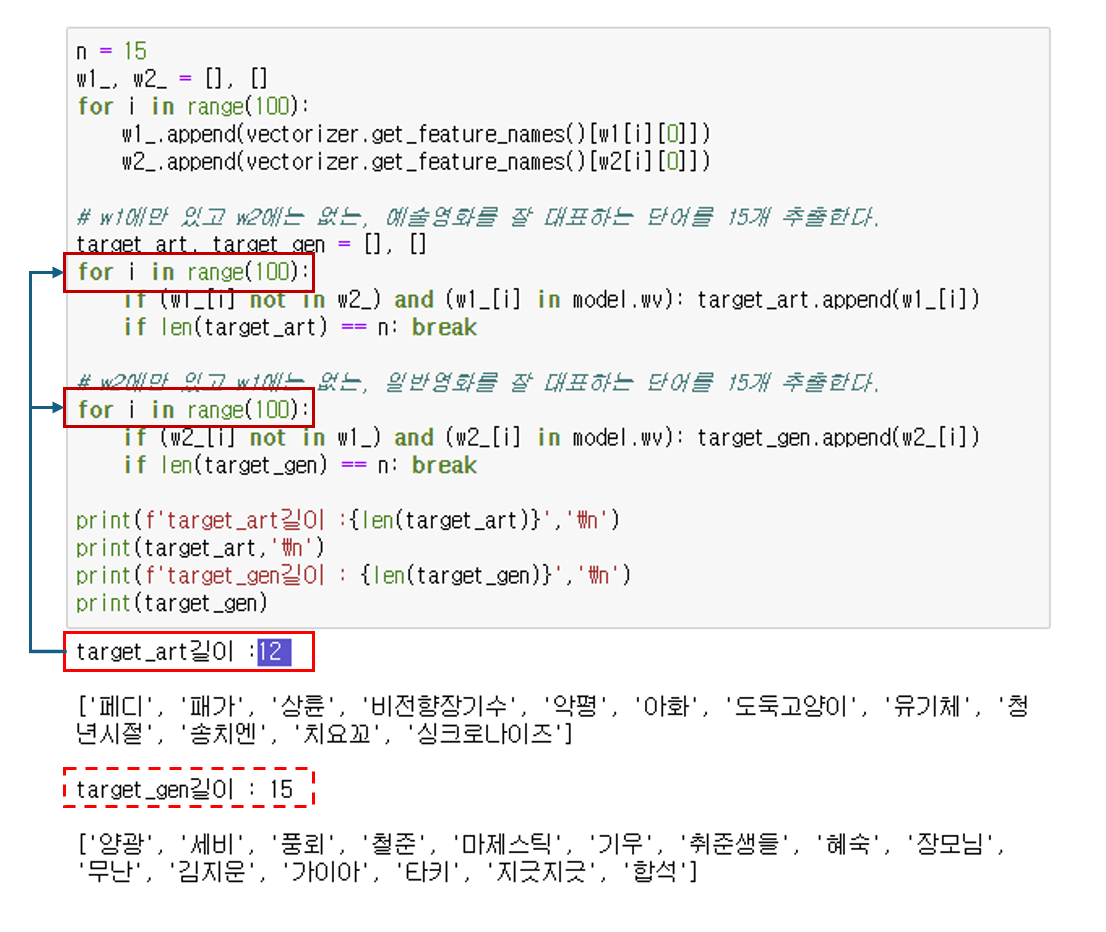

In [19]:
genres = []
for file_name in genre_txt:
    genres.append(read_token_1(file_name))  # 각 장르별로 중복 제거된 단어 추출 후 저장
    
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genres)

print(X.shape)

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
(21, 42191)


### TF-IDF를 적용했을 때의 문제점 해결 시도(2/2)
2. **대표성 문제**: TF-IDF는 특정 문서에서 자주 사용되는 단어에 높은 점수를 부여하는 방식이기 때문에, 장르의 대표성을 충분히 반영하지 못할 수 있습니다. 의미상 특정 장르를 잘 표현하는 단어들이 TF-IDF 순위에서 배제될 수 있습니다.   
    
    **개선 시도**
    - attr.append(vectorizer.get_feature_names()[w[i][j][0]]) # <개선>    
    
    이 부분에서는 TF-IDF로 추출된 단어 중 Word2Vec 모델에 존재하는 단어만을 사용해 속성 단어 셋을 구성합니다.   
    
    => 이를 통해 TF-IDF의 한계로 인해 의미 있는 단어가 빠지거나 잘못된 단어가 포함되는 문제를 해결하고, 더 의미 있는 대표 단어 셋을 구축하도록 개선했습니다.    
    

In [23]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i] + ':\n')  # 장르 이름 출력 후 줄 바꿈
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]]) # <개선>
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print('\n')

SF:

벌칸, 제브라맨, 쇄국, 기생동물, 트렌턴, 송수관, 써로게이트, 블랙옥스, 게릴라군, 제크, 분파, 산성비, 콜로서스, 코언, 가고일, 

가족:

누키, 스위드, 크누드, 슈이트, 최호, 아주르, 볼러스, 크시, 마갈, 매킷, 씨제이, 콜랴, 블리자드, 전폐, 왕창, 

공연:

리두, 핑커톤, 발트뷔네, 게슬러, 굴리엘모, 만토바, 프로스페, 뱅쿠오, 리골레토, 레나토, 잘츠부르크, 탄호이저, 페란도, 스메타나, 파르지팔, 

공포(호러):

카데바, 와카쿠보, 분홍신, 밀랍인형, 송치엔, 사액, 다크니스, 목사관, 나쯔미, 알레나, 양초, 헌티드, 폰티풀, 맥켈비, 고징, 

기타:

유철, 윤미연, 청파동, 쥐포, 윤채, 구일만, 시엠, 현성은, 지서, 장공, 구유, 혜화동, 완섭, 루하시, 세르지뉴, 

다큐멘터리:

라쿠센엔, 중병, 드파르동, 풍동, 협동조합, 공화, 조업, 첨가제, 안나푸르나, 천안함, 대한문, 재독, 아이누, 선산, 맥켈위, 

드라마:

마제스틱, 기우, 페디, 이락, 가필, 박사학위, 페이소스, 강희, 용범, 스코어, 불견, 다현, 고광렬, 캠브리지, 스카티, 

멜로로맨스:

철준, 난주, 상륜, 리싱, 입덧, 진평, 송연, 교보, 노부꼬, 일봉, 케림, 헤이타, 띵동, 에이치, 건후, 

뮤지컬:

프롤, 프롤로, 노트르담, 샤오캉, 페뷔스, 제루샤, 니웨, 뮤지컬영화, 살리에리, 캬바레, 멘델스존, 샌드맨, 장학우, 줄리엔, 로산, 

미스터리:

한준, 기호학자, 그윈플렌, 라트렐, 헬마, 종섭, 반물질, 자윤, 샤오싱, 고발장, 거미숲, 장펑, 태환, 일루미나티, 시엘, 

범죄:

니틀스, 애디슨, 와처스, 한길수, 부르투스, 맥베드, 유안펭밍, 송진밍, 이강희, 이성호, 이도윤, 민증, 샤오창, 삼면, 필재, 

사극:

신기전, 광헌, 루안, 설주, 채선, 신재효, 세자, 홍리, 윤복, 히파티아, 노준, 바토리, 임숭재, 아가멤논, 허균, 

서부극(웨스턴):

그레이프바인, 개릿, 마적, 바운티, 

**위 내용 표로 정리하기**

In [34]:
import pandas as pd

# 데이터프레임 생성
data = {genre_name[i]: attributes[i] for i in range(len(attributes))}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))

# NaN 값을 빈 문자열로 채우기
df.fillna('', inplace=True)

# 데이터프레임 출력 (1번째 열부터 7번째 열까지만 선택)
df_subset = df.iloc[:, :7]
print(df_subset)

# 데이터프레임 출력 (전체)
# print(df)

       SF    가족     공연 공포(호러)    기타  다큐멘터리   드라마
0      벌칸    누키     리두    카데바    유철   라쿠센엔  마제스틱
1    제브라맨   스위드    핑커톤   와카쿠보   윤미연     중병    기우
2      쇄국   크누드   발트뷔네    분홍신   청파동   드파르동    페디
3    기생동물   슈이트    게슬러   밀랍인형    쥐포     풍동    이락
4     트렌턴    최호   굴리엘모    송치엔    윤채   협동조합    가필
5     송수관   아주르    만토바     사액   구일만     공화  박사학위
6   써로게이트   볼러스   프로스페   다크니스    시엠     조업  페이소스
7    블랙옥스    크시    뱅쿠오    목사관   현성은    첨가제    강희
8    게릴라군    마갈   리골레토    나쯔미    지서  안나푸르나    용범
9      제크    매킷    레나토    알레나    장공    천안함   스코어
10     분파   씨제이  잘츠부르크     양초    구유    대한문    불견
11    산성비    콜랴   탄호이저    헌티드   혜화동     재독    다현
12   콜로서스  블리자드    페란도    폰티풀    완섭    아이누   고광렬
13     코언    전폐   스메타나    맥켈비   루하시     선산  캠브리지
14    가고일    왕창   파르지팔     고징  세르지뉴    맥켈위   스카티


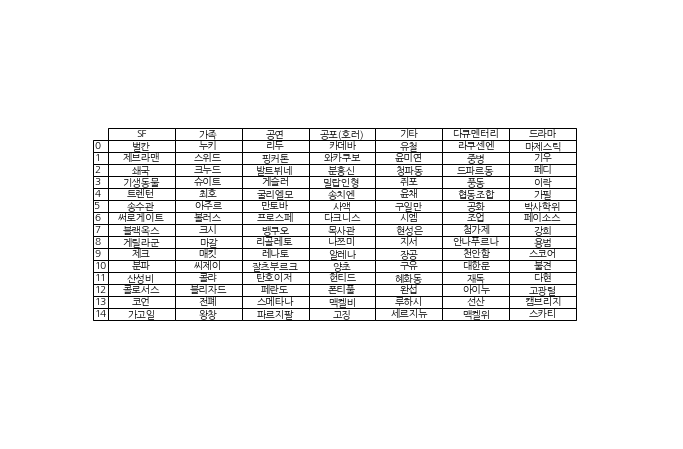

In [41]:
# 시각화
import matplotlib.pyplot as plt
import pandas.plotting as pd_plotting
import matplotlib

# 한글 폰트 설정
matplotlib.rcParams['font.family'] = 'NanumGothic'

fig, ax = plt.subplots(figsize=(12,8))
ax.axis('off')

# 테이블 생성
# df_1 = df # (전체)
df_1 = df_subset # df.iloc[:, :7]
pd_plotting.table(ax, df_1, loc='center', cellLoc='center', colWidths=[0.1] * len(df_subset.columns))

plt.show()

---

# 🍀STEP 4. WEAT score 계산과 시각화
- 편향성을 측정 및 WEAT score 계산  
- Heatmap로 시각화   
---

### 한글 폰트 및 부호 설정

In [66]:
# 시각화

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 한글 폰트 설정
matplotlib.rcParams['font.family'] = 'NanumGothic'

# 마이너스 부호 설정
plt.rcParams['axes.unicode_minus'] = True

### 편향성을 측정 및 WEAT score 계산

In [60]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
# 장르별 편향성 점수를 저장할 행렬(matrix)을 생성합니다. 각 장르 간의 WEAT 점수를 저장하기 위해
# 행렬 크기는 (장르 수 x 장르 수)로 만들어집니다. 초기 값은 모두 0으로 설정됩니다.

print("matrix 완성")

X = np.array([model.wv[word] for word in target_art])
# target_art에 포함된 단어들의 Word2Vec 임베딩 벡터를 가져와 numpy 배열 X로 저장합니다.
# 이는 WEAT 점수를 계산할 때 사용될 예술영화를 대표하는 단어들의 임베딩 벡터입니다.

Y = np.array([model.wv[word] for word in target_gen])
# target_gen에 포함된 단어들의 Word2Vec 임베딩 벡터를 가져와 numpy 배열 Y로 저장합니다.
# 이는 WEAT 점수를 계산할 때 사용될 일반영화를 대표하는 단어들의 임베딩 벡터입니다.

for i in range(len(genre_name)-1):
    # 장르의 모든 조합을 반복문으로 돌기 위해 첫 번째 인덱스를 설정합니다.
    for j in range(i+1, len(genre_name)):
        # 두 번째 인덱스를 설정하여 모든 (i, j) 조합에 대해 반복문을 돌립니다 (i < j).
        # 대칭 행렬이므로 중복 계산을 피하기 위해 j는 i보다 큰 값부터 시작합니다.

        A = np.array([model.wv[word] for word in attributes[i]])
        # 장르 i에 속하는 단어들의 Word2Vec 임베딩 벡터를 가져와 numpy 배열 A로 저장합니다.
        # 이는 WEAT 점수 계산 시 속성 집합 A로 사용됩니다.

        B = np.array([model.wv[word] for word in attributes[j]])
        # 장르 j에 속하는 단어들의 Word2Vec 임베딩 벡터를 가져와 numpy 배열 B로 저장합니다.
        # 이는 WEAT 점수 계산 시 속성 집합 B로 사용됩니다.

        matrix[i][j] = round(weat_score(X, Y, A, B), 3)
        # WEAT 점수를 계산하고 행렬의 (i, j) 위치에 저장합니다.
        # X, Y는 타겟 단어 집합이고, A, B는 속성 단어 집합입니다. 이 점수는 i와 j 장르 간의 편향성을 나타냅니다.

print('matrix의 weat_score 계산')


matrix 완성
matrix의 weat_score 계산


In [61]:
type(matrix[i][j])

numpy.float32

In [67]:
# WEAT 점수 테이블 생성
table_weatscore = []
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        a = 0
        if matrix[i][j] > 0:
            a = 1
        else:
            a = -1
        table_weatscore.append([genre_name[i], genre_name[j], matrix[i][j], a])
# 데이터프레임으로 변환하여 테이블 생성
df_weatscore = pd.DataFrame(table_weatscore, columns=['배열 A', '배열 B', 'WEAT 점수', '예술/일반 (1/-1)'])
print(df_weatscore)        

     배열 A    배열 B  WEAT 점수  예술/일반 (1/-1)
0      SF      가족    1.359             1
1      SF      공연    1.101             1
2      SF  공포(호러)    1.159             1
3      SF      기타    1.179             1
4      SF   다큐멘터리    0.662             1
..    ...     ...      ...           ...
205  어드벤처     코미디    0.340             1
206  어드벤처     판타지   -0.328            -1
207    전쟁     코미디    0.911             1
208    전쟁     판타지    0.774             1
209   코미디     판타지   -0.536            -1

[210 rows x 4 columns]


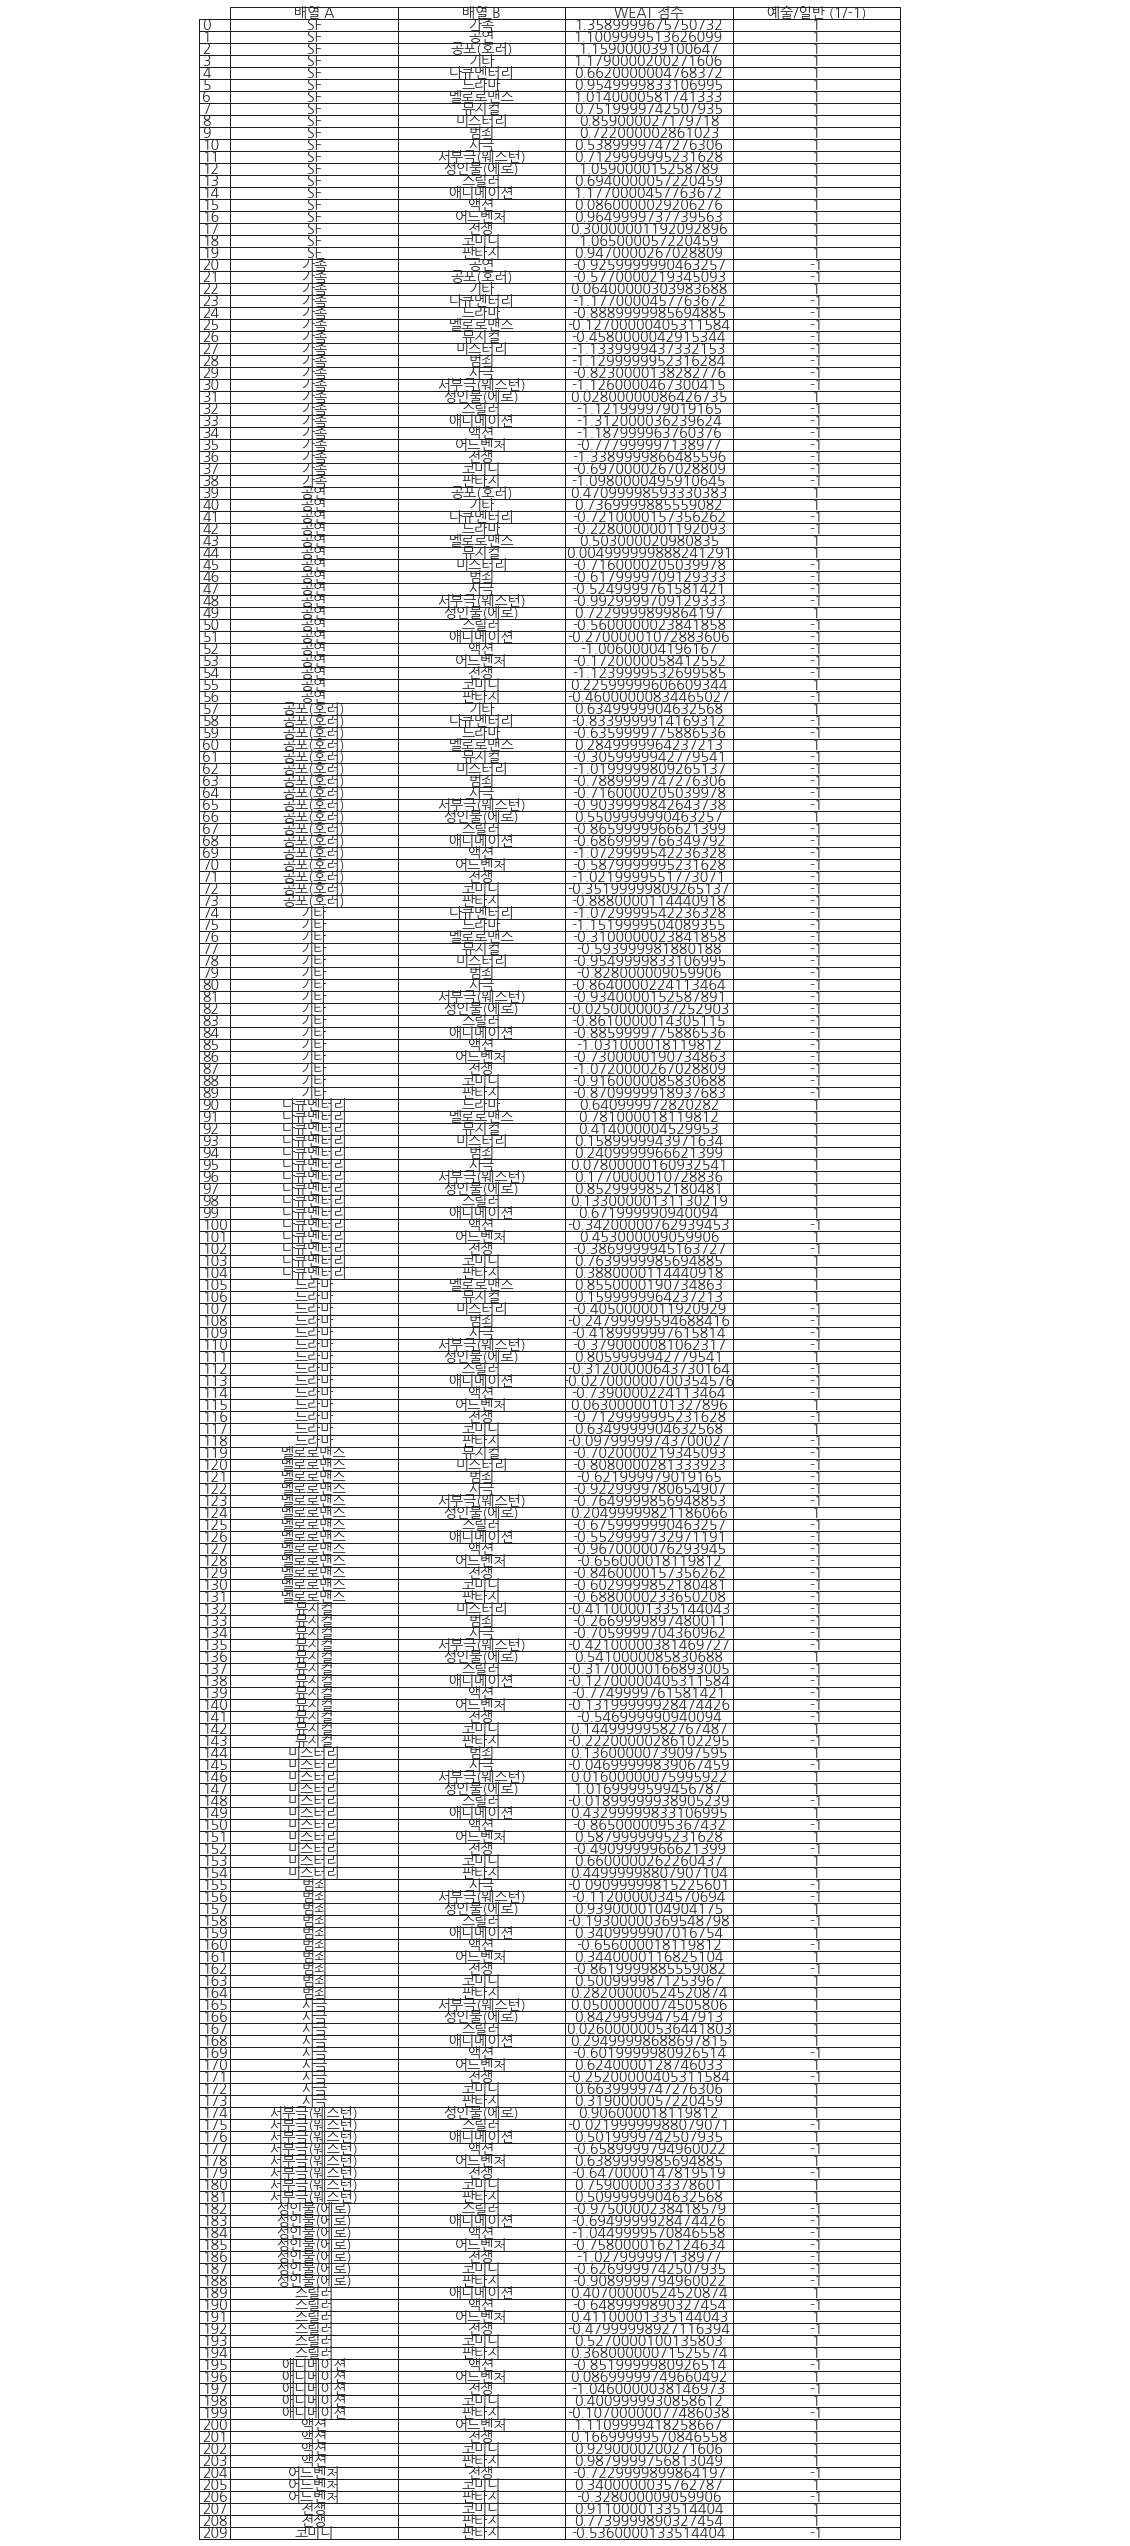

In [79]:
#시각화
fig, ax = plt.subplots(figsize=(20, 15))  
ax.axis('off')

# 테이블 생성 (WEAT 점수 테이블 시각화)
table = pd_plotting.table(ax, df_weatscore, loc='center', cellLoc='center', colWidths=[0.15] * len(df_weatscore.columns))

# 글씨 크기 설정
table.auto_set_font_size(False)
table.set_fontsize(14)

plt.show()


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


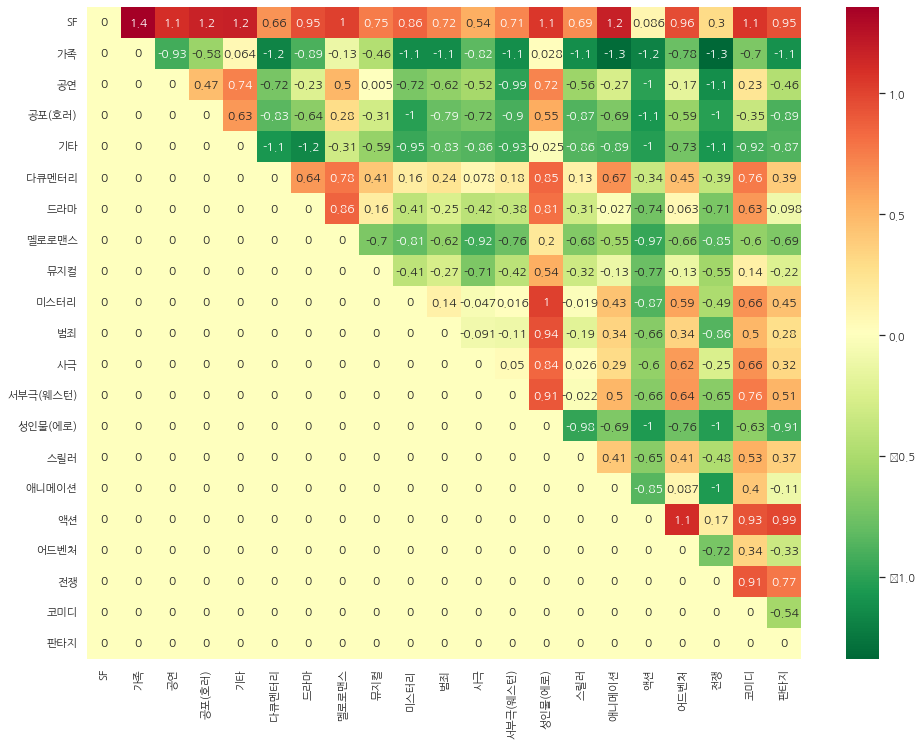

In [69]:
np.random.seed(0)

# 히트맵 크기 설정
plt.figure(figsize=(16, 12))  # width와 height

# 히트맵 생성
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r')
plt.show()


👁️👁️Review : 